In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [30]:
csq = pd.read_csv('csq.gz', sep = " ", header= None)
samples= pd.read_csv('samples.gz', sep = " ", header= None)
csq = csq.values
samples = samples.values

In [31]:
m_true = np.array([1E4, 1E3, 0.1, 0.1])
m_0 = [10**(3.9), 10**(5.2), 1.5, 0.3]

nstep= 10000
csq_start = 123879376900.95654
param_length = np.shape(samples)[1]

In [32]:
#def mcmc(start_guess, samples, csq, csq_start, nstep):
def mcmc(samples, csq, nstep):

    #definig the chain
    chain = np.empty((nstep, np.shape(samples)[1]))
    chain[0, :] = samples[0, :]
     
    #defining the chi-square array
    chisq = np.zeros(nstep)
    #chisq[0] = chisq_start
    chisq[0] = csq[0]

    #defining the acceptance ratio
    acceptance_ratio = 0
            
    #the chain 
    for i in range(1, nstep):
        new_param = samples[i, :]
        new_chisq =  csq[i]      
        if new_chisq <= chisq[i-1]:
            acceptance_ratio = acceptance_ratio + 1
            chisq[i] = new_chisq
            chain[i, :] = new_param 
        else :
            betta = 20
            if np.random.rand(1)<betta*(np.exp(-0.5*(new_chisq-chisq[i-1]))):
                acceptance_ratio = acceptance_ratio + 1
                chisq[i] = new_chisq
                chain[i, :] = new_param
            else:
                chisq[i] = chisq[i-1]
                chain[i, :] = chain[i-1, :]          
    return chain, chisq, acceptance_ratio/nstep

In [33]:
#params, cs, acceptance_ratio = mcmc(m_0, samples, csq, csq_start, nstep)
params, cs, acceptance_ratio = mcmc(samples, csq, nstep)

In [34]:
mcmc_param= np.empty(param_length)
for i in range(param_length):
    mcmc_param[i] = np.mean(params[:,i]) #array of best parameters  

In [35]:
mcmc_param

array([1.00000135e+04, 1.00027921e+03, 9.99833496e-02, 9.99996780e-02])

In [36]:
print('True Parameters: ' + repr(m_true))
print('Starting Parameters: ' + repr(samples[0, :]))
print('MCMC Fitted Parameters: ' + repr(mcmc_param))
print('error bar of fit: ' + repr(np.std(params, axis=0)))
print('error of the fit: ' +repr((abs(m_true-mcmc_param)/m_true)*100))
print("Chi-squared of original guess:"+ repr(cs[0]))
#print("Chi-squared of MCMC result:"+ repr(2996.786984538737))
print("acceptance_ratio for %d Steps: " %nstep + repr(acceptance_ratio*100) +"%")

True Parameters: array([1.e+04, 1.e+03, 1.e-01, 1.e-01])
Starting Parameters: array([9.99998275e+03, 9.99419824e+02, 1.00025031e-01, 1.00001169e-01])
MCMC Fitted Parameters: array([1.00000135e+04, 1.00027921e+03, 9.99833496e-02, 9.99996780e-02])
error bar of fit: array([3.47276797e-02, 3.89323776e+00, 3.62993127e-04, 3.31868598e-06])
error of the fit: array([0.00013519, 0.02792146, 0.01665041, 0.00032195])
Chi-squared of original guess:87.99640510893003
acceptance_ratio for 10000 Steps: 20.5%


In [37]:
#Does the True value lie within the error bar of the fitted value?
np.std(params, axis=0) > abs(m_true-mcmc_param)

array([ True,  True,  True,  True])

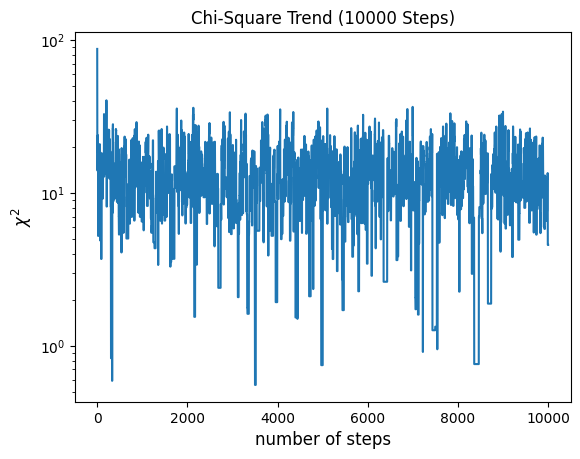

In [38]:
plt.semilogy(cs)
plt.xlabel('number of steps', fontsize=12)
plt.title ('Chi-Square Trend (%d Steps)'%nstep, fontsize=12)
plt.ylabel('$\chi^2$', fontsize=12)
plt.savefig('csq_trend_known_curve.png')
plt.show()

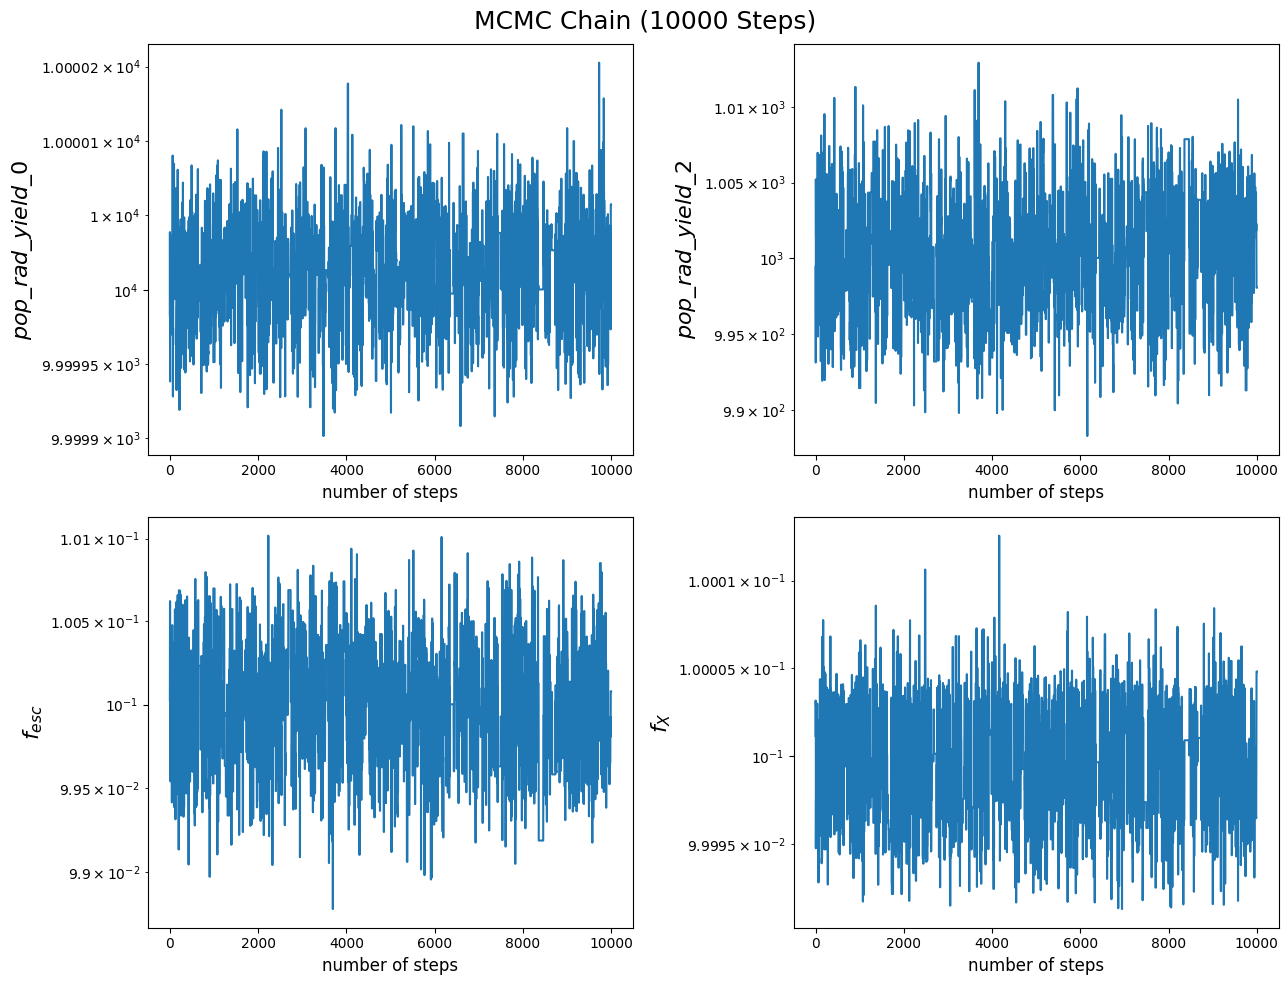

In [39]:
fig3, ax_list = plt.subplots(2, 2, figsize=(13,10))
fig3.suptitle('MCMC Chain (%d Steps)'%nstep, fontsize=18)
ax_list[0, 0].semilogy(params[:,0])
#dict_true = {'pop_rad_yield_0_': 1E4, 'pop_rad_yield_2_': 1E3, 'fesc': 0.1, 'fX': 0.1}
#ax_list[0, 0].set_ylim(bottom=9.999E3, top=1.0001E4)
ax_list[0, 0].set_ylabel('$pop\_rad\_yield\_0$', fontsize=16)
ax_list[0, 0].set_xlabel('number of steps', fontsize=12)

ax_list[0, 1].semilogy(params[:,1])
#ax_list[0, 1].set_ylim(bottom= 9.997E4, top=1.001E5)
ax_list[0, 1].set_ylabel('$pop\_rad\_yield\_2$', fontsize=16)
ax_list[0, 1].set_xlabel('number of steps', fontsize=12)

ax_list[1, 0].semilogy(params[:,2])
#ax_list[1, 0].set_ylim(bottom=1.699, top=1.701)
ax_list[1, 0].set_ylabel('$f_{esc}$', fontsize=16)
ax_list[1, 0].set_xlabel('number of steps', fontsize=12)

ax_list[1, 1].semilogy(params[:,3])
#ax_list[1, 1].set_ylim(bottom=9.99E-2, top= 1.001E-1)
ax_list[1, 1].set_ylabel('$f_X$', fontsize=16)
ax_list[1, 1].set_xlabel('number of steps', fontsize=12)
plt.tight_layout()
plt.savefig('chain_known_curve.png')
plt.show()


In [40]:
#Fourier Transform
ps = np.zeros((nstep, param_length))
for i in range(param_length):
    ps[:, i] = np.abs(np.fft.fft(params[:, i]))**2
    
freqs = np.fft.rfftfreq(nstep)
idx = np.argsort(freqs)

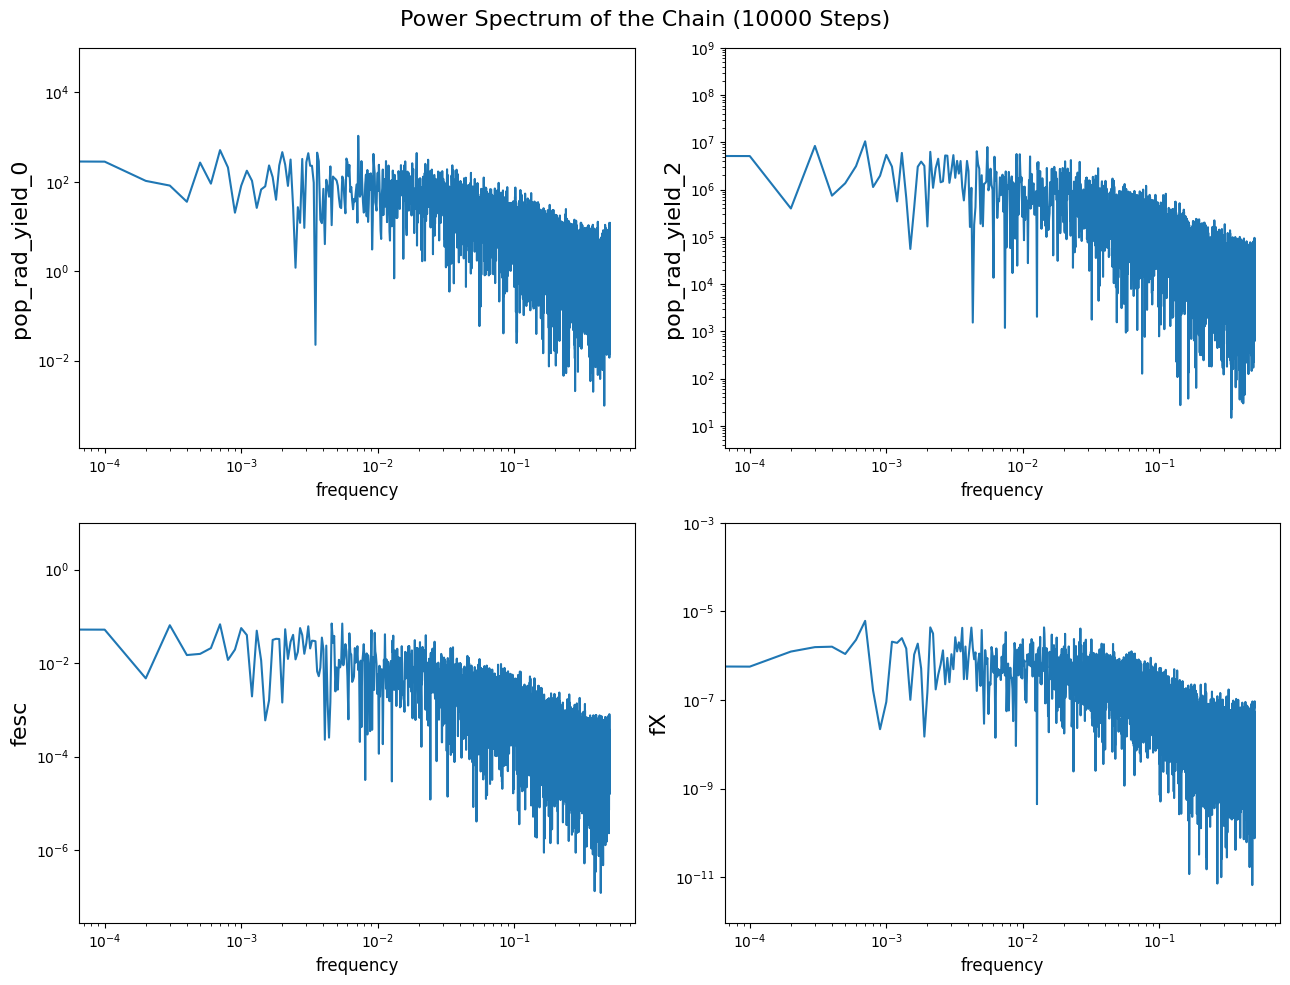

In [41]:
fig4, ax_list = plt.subplots(2, 2, figsize=(13,10))
fig4.suptitle('Power Spectrum of the Chain (%d Steps)'%nstep, fontsize=16)

ax_list[0, 0].loglog(freqs[idx], ps[idx, 0])
ax_list[0, 0].set_ylabel('pop_rad_yield_0', fontsize=16)
ax_list[0, 0].set_xlabel('frequency', fontsize=12)
ax_list[0, 0].set_ylim(top = 1E5)

ax_list[0, 1].loglog(freqs[idx], ps[idx, 1])
ax_list[0, 1].set_ylabel('pop_rad_yield_2', fontsize=16)
ax_list[0, 1].set_xlabel('frequency', fontsize=12)
ax_list[0, 1].set_ylim(top = 1E9)

ax_list[1, 0].loglog(freqs[idx], ps[idx, 2])
ax_list[1, 0].set_ylabel('fesc', fontsize=16)
ax_list[1, 0].set_xlabel('frequency', fontsize=12)
ax_list[1, 0].set_ylim(top = 1E1)

ax_list[1, 1].loglog(freqs[idx], ps[idx, 3])
ax_list[1, 1].set_ylabel('fX', fontsize=16)
ax_list[1, 1].set_xlabel('frequency', fontsize=12)
ax_list[1, 1].set_ylim(top = 1E-3)

plt.tight_layout()
plt.savefig('power_spectrum_known_curve.png')
plt.show()


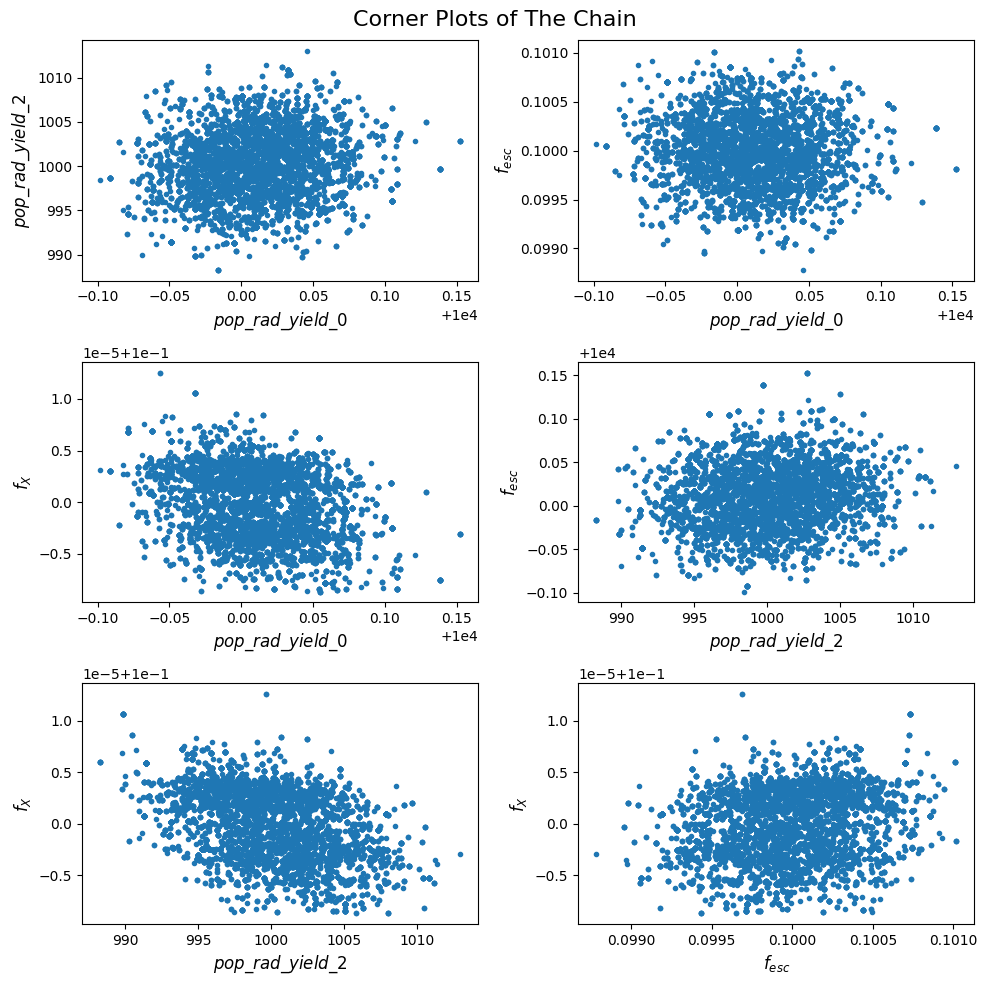

In [42]:
params_cut = params[500:, :]
#params_cut = np.copy(params)
fig5, ax_list = plt.subplots(3, 2, figsize=(10,10))
fig5.suptitle('Corner Plots of The Chain', fontsize=16)

ax_list[0, 0].plot(params_cut[:, 0], params_cut[:, 1], linestyle = "", marker=".")
ax_list[0, 0].set_ylabel('$pop\_rad\_yield\_2$', fontsize=12)
ax_list[0, 0].set_xlabel('$pop\_rad\_yield\_0$', fontsize=12)

ax_list[0, 1].plot(params_cut[:, 0], params_cut[:, 2], linestyle = "", marker=".")
ax_list[0, 1].set_ylabel('$f_{esc}$', fontsize=12)
ax_list[0, 1].set_xlabel('$pop\_rad\_yield\_0$', fontsize=12)
    
ax_list[1, 0].plot(params_cut[:, 0], params_cut[:, 3], linestyle = "", marker=".")
ax_list[1, 0].set_ylabel('$f_X$', fontsize=12)
ax_list[1, 0].set_xlabel('$pop\_rad\_yield\_0$', fontsize=12)

ax_list[1, 1].plot(params_cut[:, 1], params_cut[:, 0], linestyle = "", marker=".")
ax_list[1, 1].set_ylabel('$f_{esc}$', fontsize=12)
ax_list[1, 1].set_xlabel('$pop\_rad\_yield\_2$', fontsize=12)

ax_list[2, 0].plot(params_cut[:, 1], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 0].set_ylabel('$f_X$', fontsize=12)
ax_list[2, 0].set_xlabel('$pop\_rad\_yield\_2$', fontsize=12)

ax_list[2, 1].plot(params_cut[:, 2], params_cut[:, 3], linestyle = "", marker=".")
ax_list[2, 1].set_ylabel('$f_X$', fontsize=12)
ax_list[2, 1].set_xlabel('$f_{esc}$', fontsize=12)

plt.tight_layout()
plt.savefig('corner_plots_known_curve.png')
plt.show()